In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

### YOLO pretraining on RSNA Dataset

In [89]:
loss_path = "./losses_pretrained/"
train_loss = np.load(loss_path + "yolov5_train_loss_39.np.npy")
val_loss = np.load(loss_path + "yolov5_val_loss_39.np.npy" )
assert len(val_loss) == len(train_loss)

In [90]:
train_single_losses = np.load(loss_path + "yolov5_train_loss_single_39.np.npy")
val_single_losses = np.load(loss_path + "yolov5_val_loss_single_39.np.npy")

In [91]:
file = open(loss_path + "yolov5_general_test_results_39.pickle",'rb')
metrics_list = pickle.load(file)
file.close()

type(metrics_list)

list

In [92]:
train_loss[:,3]

array([    0.20054,      0.1653,     0.15663,     0.15213,     0.15052,     0.14797,     0.14762,       0.146,     0.14403,     0.14376,     0.14322,     0.14269,     0.14239,     0.14211,     0.14188,     0.14126,     0.14036,     0.14161,     0.13895,     0.14125,     0.13831,     0.13814,     0.13648,     0.13767,
             0.137,     0.13716,     0.13575,     0.13533,     0.13613,     0.13385,     0.13492,      0.1343,     0.13458,     0.13405,     0.13316,     0.13498,      0.1325,     0.13219,      0.1323,     0.13104], dtype=float32)

C:\Users\Julian\AppData\Local\Temp/ipykernel_18164/1227529463.py:16: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show(block=True)


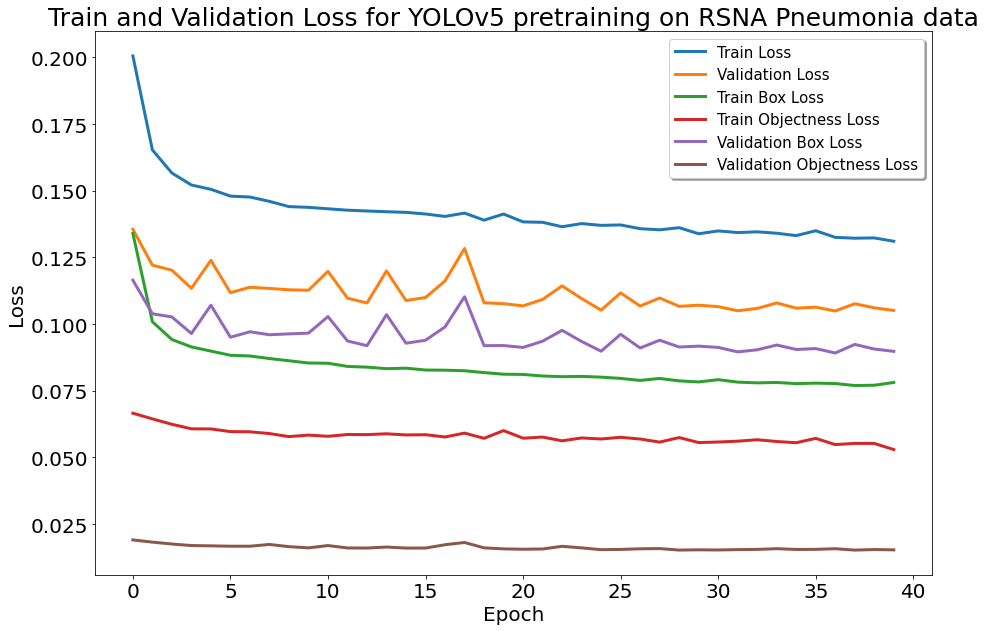

In [97]:
x = [i for i in range(len(val_loss))]

fig = plt.figure(figsize=(15,10))
plt.plot(x,train_loss[:,3] , label="Train Loss", linewidth=3)
plt.plot(x,val_loss[:,3], label="Validation Loss", linewidth=3)
plt.plot(x,train_loss[:,0], label="Train Box Loss", linewidth=3)
plt.plot(x,train_loss[:,1], label="Train Objectness Loss", linewidth=3)
plt.plot(x,val_loss[:,0], label="Validation Box Loss", linewidth=3)
plt.plot(x,val_loss[:,1], label="Validation Objectness Loss", linewidth=3)
plt.title("Train and Validation Loss for YOLOv5 pretraining on RSNA Pneumonia data", fontsize=25)
plt.ylabel("Loss",fontsize=20)
plt.xlabel("Epoch",fontsize=20)
plt.legend(shadow=True, prop={'size': 15})
plt.xticks(fontsize=20 )
plt.yticks(fontsize=20 )
plt.show(block=True)
fig.savefig("../../imgs/models/loss_pretrained_ciou_42.jpg",dpi=200)

In [94]:
precision, recall, ap, f1, ap_class, ap50, mp, mr, map50 = [], [], [], [], [], [], [], [], []

In [95]:
for metrics in metrics_list:
    precision.append(metrics["precision"][0])
    recall.append(metrics["recall"][0])
    ap.append(metrics["ap"][0])
    f1.append(metrics["f1"][0])
    ap_class.append(metrics["ap_class"][0])
    ap50.append(metrics["ap50"][0])
    mp.append(metrics["mp"])
    mr.append(metrics["mr"])
    map50.append(metrics["map50"])

C:\Users\Julian\AppData\Local\Temp/ipykernel_18164/4085231859.py:14: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show(block=True)


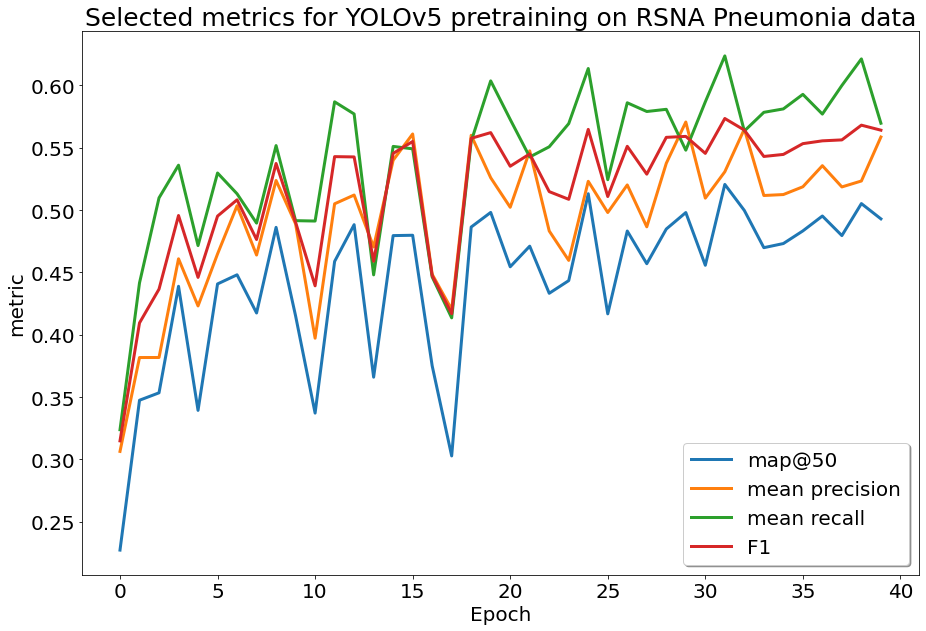

In [96]:
x = [i for i in range(len(map50))]

fig = plt.figure(figsize=(15,10))
plt.plot(x,map50 , label="map@50", linewidth=3)
plt.plot(x,mp, label="mean precision", linewidth=3)
plt.plot(x,mr, label="mean recall", linewidth=3)
plt.plot(x,f1, label="F1", linewidth=3)
plt.title("Selected metrics for YOLOv5 pretraining on RSNA Pneumonia data", fontsize=25)
plt.ylabel("metric",fontsize=20)
plt.xlabel("Epoch",fontsize=20)
plt.legend(shadow=True, prop={'size': 20})
plt.xticks(fontsize=20 )
plt.yticks(fontsize=20 )
plt.show(block=True)
path = "../../imgs/models/metrics_ciou_pretrained_yolo_42.png"
fig.savefig(path,dpi=200)

### YOLO training on SIIM

In [113]:
loss_path = "./losses_final/"
train_loss = np.load(loss_path + "yolov5_train_loss_99.np.npy")
val_loss = np.load(loss_path + "yolov5_val_loss_99.np.npy" )
assert len(val_loss) == len(train_loss)

In [114]:
file = open(loss_path + "yolov5_general_test_results_99.pickle",'rb')
metrics_list = pickle.load(file)
file.close()

type(metrics_list)

list

In [115]:
train_loss

array([[    0.09233,    0.071039,           0,     0.16337],
       [   0.090826,    0.074474,           0,      0.1653],
       [   0.089898,    0.070312,           0,     0.16021],
       [   0.089481,    0.070724,           0,      0.1602],
       [   0.089387,    0.071476,           0,     0.16086],
       [    0.08917,     0.07287,           0,     0.16204],
       [   0.089136,    0.070789,           0,     0.15992],
       [   0.088679,     0.07099,           0,     0.15967],
       [   0.088948,    0.070277,           0,     0.15923],
       [    0.08863,    0.072569,           0,      0.1612],
       [   0.088575,    0.069845,           0,     0.15842],
       [   0.089163,    0.071187,           0,     0.16035],
       [   0.087433,    0.072708,           0,     0.16014],
       [   0.088146,    0.073088,           0,     0.16123],
       [   0.087958,    0.070587,           0,     0.15855],
       [   0.087522,    0.071862,           0,     0.15938],
       [   0.087094,    

C:\Users\Julian\AppData\Local\Temp/ipykernel_18164/301631837.py:16: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show(block=True)


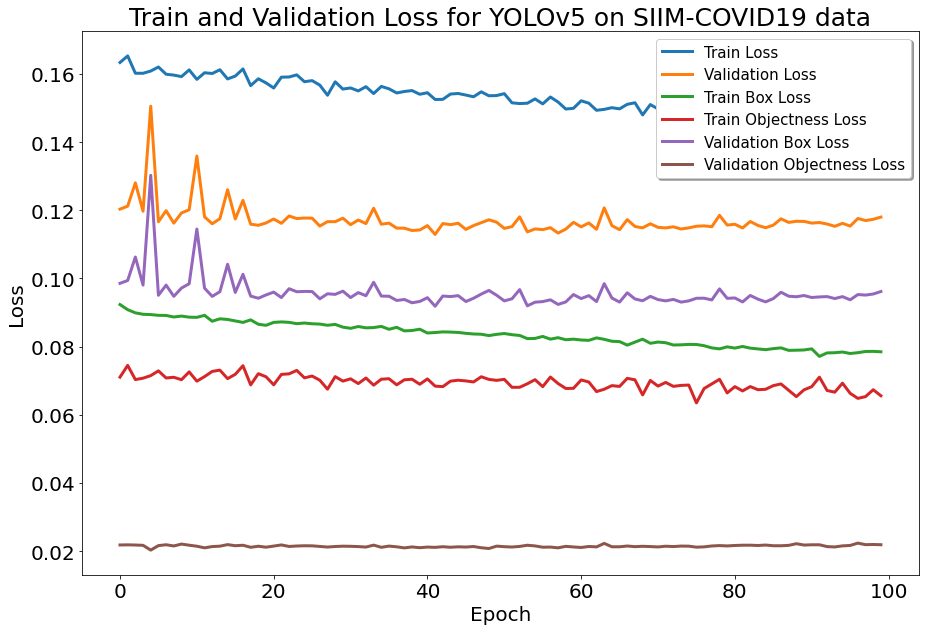

In [116]:
x = [i for i in range(len(val_loss))]

fig = plt.figure(figsize=(15,10))
plt.plot(x,train_loss[:,3] , label="Train Loss", linewidth=3)
plt.plot(x,val_loss[:,3], label="Validation Loss", linewidth=3)
plt.plot(x,train_loss[:,0], label="Train Box Loss", linewidth=3)
plt.plot(x,train_loss[:,1], label="Train Objectness Loss", linewidth=3)
plt.plot(x,val_loss[:,0], label="Validation Box Loss", linewidth=3)
plt.plot(x,val_loss[:,1], label="Validation Objectness Loss", linewidth=3)
plt.title("Train and Validation Loss for YOLOv5 on SIIM-COVID19 data", fontsize=25)
plt.ylabel("Loss",fontsize=20)
plt.xlabel("Epoch",fontsize=20)
plt.legend(shadow=True,loc="best", prop={'size': 15})
plt.xticks(fontsize=20 )
plt.yticks(fontsize=20 )
plt.show(block=True)
fig.savefig("../../imgs/models/loss_yolo_42_siim.png",dpi=200)

In [117]:
precision, recall, ap, f1, ap_class, ap50, mp, mr, map50 = [], [], [], [], [], [], [], [], []
for metrics in metrics_list:
    precision.append(metrics["precision"][0])
    recall.append(metrics["recall"][0])
    ap.append(metrics["ap"][0])
    f1.append(metrics["f1"][0])
    ap_class.append(metrics["ap_class"][0])
    ap50.append(metrics["ap50"][0])
    mp.append(metrics["mp"])
    mr.append(metrics["mr"])
    map50.append(metrics["map50"])

C:\Users\Julian\AppData\Local\Temp/ipykernel_18164/1597941464.py:14: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show(block=True)


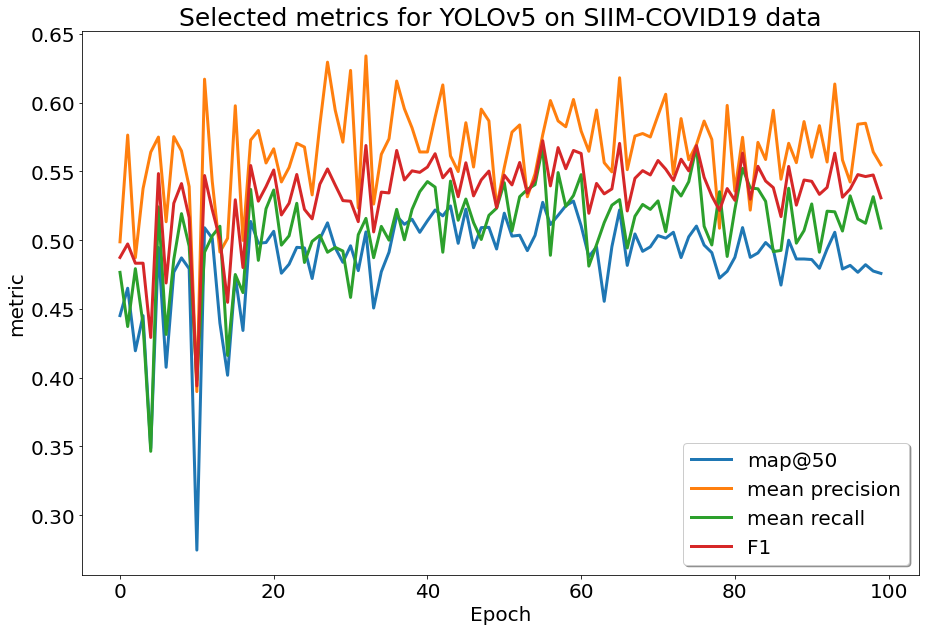

In [118]:
x = [i for i in range(len(map50))]

fig = plt.figure(figsize=(15,10))
plt.plot(x,map50 , label="map@50", linewidth=3)
plt.plot(x,mp, label="mean precision", linewidth=3)
plt.plot(x,mr, label="mean recall", linewidth=3)
plt.plot(x,f1, label="F1", linewidth=3)
plt.title("Selected metrics for YOLOv5 on SIIM-COVID19 data", fontsize=25)
plt.ylabel("metric",fontsize=20)
plt.xlabel("Epoch",fontsize=20)
plt.legend(shadow=True, prop={'size': 20})
plt.xticks(fontsize=20 )
plt.yticks(fontsize=20 )
plt.show(block=True)
fig.savefig("../../imgs/models/metrics_yolo_30_siim.png",dpi=200)

## Inference

In [2]:
import torch
from models.yolo import Model
from utils.datasets import LoadImages
from utils.general import check_img_size, non_max_suppression, xywhn2xyxy
import matplotlib.patches as patches

In [3]:
IMAGE_SIZE = 512
CONFIDENCE_THRESHOLD = 0.3
IOU_THRESHOLD = 0.2

In [6]:
model = Model(cfg="yolo5l.yaml",ch=3,nc=1)
trained_weights = torch.load("./models_final_giou_40/yolov5_epoch_39.pt")
model.load_state_dict(trained_weights, strict=False)  # load
model.eval()

stride = int(model.stride.max())  # model stride
img_size = check_img_size(IMAGE_SIZE, s=stride)  # check img_size
print(img_size)

D:\Anaconda\envs\aml\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


512


In [7]:
# see sample predcition on one image in validation
test_image_path = "../../data/siim-covid19-detection/images/train/292c0aeda46d.png"
test_label_path = "../../data/siim-covid19-detection/labels/train/292c0aeda46d.txt"

In [14]:
samples = LoadImages(test_image_path, img_size, stride).__iter__().__next__()
samples[1]

array([[[114, 114, 114, ..., 114, 114, 114],
        [114, 114, 114, ..., 114, 114, 114],
        [114, 114, 114, ..., 114, 114, 114],
        ...,
        [114, 114, 114, ..., 114, 114, 114],
        [114, 114, 114, ..., 114, 114, 114],
        [114, 114, 114, ..., 114, 114, 114]],

       [[114, 114, 114, ..., 114, 114, 114],
        [114, 114, 114, ..., 114, 114, 114],
        [114, 114, 114, ..., 114, 114, 114],
        ...,
        [114, 114, 114, ..., 114, 114, 114],
        [114, 114, 114, ..., 114, 114, 114],
        [114, 114, 114, ..., 114, 114, 114]],

       [[114, 114, 114, ..., 114, 114, 114],
        [114, 114, 114, ..., 114, 114, 114],
        [114, 114, 114, ..., 114, 114, 114],
        ...,
        [114, 114, 114, ..., 114, 114, 114],
        [114, 114, 114, ..., 114, 114, 114],
        [114, 114, 114, ..., 114, 114, 114]]], dtype=uint8)

In [ ]:
def add_bounding_boxes(target, ax):
    boxes = target
    for box in boxes:
        mp_box = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], edgecolor="r", facecolor='none')
        ax.add_patch(mp_box)

def show_samples_for(test, train):
    fig, axs = plt.subplots(1, 2, figsize=(10,8))
    for im_i, (img, data) in enumerate([test, train]):
        ax = axs[im_i] if isinstance(axs, np.ndarray) else axs
        ax.set_title(f'Instance / Image Nr. {im_i + 1} / {2}')
        plt.figure()
        ax.imshow(img.permute(1,2,0), cmap=plt.cm.bone)
        add_bounding_boxes(data, ax)
    plt.show()

In [ ]:
def refine_det(boxes, labels, scores):
    boxes = boxes.clip(0,1)

    boxes_out = []
    labels_out = []
    scores_out = []
    for box, label, score in zip(boxes, labels, scores):
        x1, y1, x2, y2 = box
        if x1==x2 or y1==y2:
            continue
        box = [min(x1,x2), min(y1,y2), max(x1,x2), max(y1,y2)]
        boxes_out.append(box)
        labels_out.append(label)
        scores_out.append(score)
    return boxes_out, labels_out, scores_out

In [52]:
gt = torch.tensor([[0.24809027777777778, 0.422244094488189 ,0.184375, 0.3059055118110236], [
    0.7088541666666667 ,0.5190944881889764, 0.1482638888888889, 0.371259842519685
]])

tensor([[8.86703e+01, 1.56650e+02, 1.71513e+02, 2.97035e+02, 4.91695e-01, 0.00000e+00],
        [3.33376e+02, 2.13431e+02, 3.97305e+02, 3.00551e+02, 3.70996e-01, 0.00000e+00]])


tensor([[ 88.67027, 156.65039, 171.51266, 297.03549],
        [333.37573, 213.43100, 397.30481, 300.55112]])


tensor([0.49170, 0.37100])


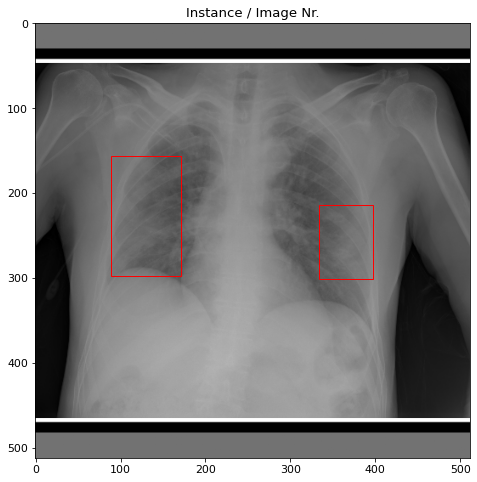

<Figure size 432x288 with 0 Axes>

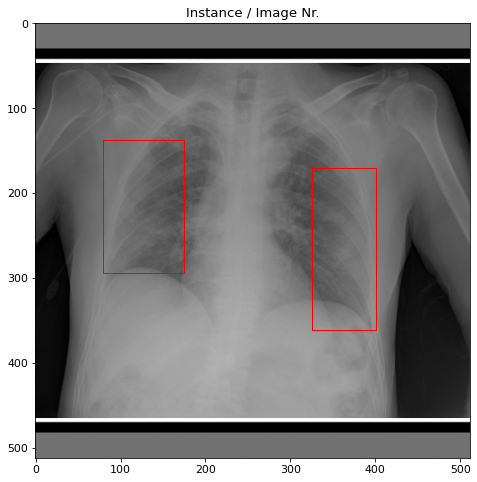

<Figure size 432x288 with 0 Axes>

In [53]:
for path, img, im0s, vid_cap in samples:
    img_height, img_width = im0s.shape[0:2]
    i_h = img.shape[1]
    i_w = img.shape[2]
    img = torch.from_numpy(img).float()
    img /= 255.0
    if img.ndimension() == 3:
         img = img.unsqueeze(0)
    
    with torch.inference_mode():
        prediction = model(img,augment=True)[0]
    
    prediction = non_max_suppression(prediction, CONFIDENCE_THRESHOLD, IOU_THRESHOLD, classes=None)
   
    #box = prediction[0][0][:4]
    
    box = prediction[0]
    print(box)
    print("\n")
    print(box[:,:4])
    print("\n")
    print(box[:,4])

    #for det in prediction:
    #    if det is not None and len(det):
     #       det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0s.shape).round()
     #       det = det.data.cpu().numpy()
   # print(f'det: {det}')

    
    # show results
    fig, axs = plt.subplots(1, 1, figsize=(10,8))
    ax = axs[0] if isinstance(axs, np.ndarray) else axs
    ax.set_title(f'Instance / Image Nr.')
    plt.figure()
    ax.imshow(img.detach().squeeze().permute(1,2,0), cmap=plt.cm.bone)
    add_bounding_boxes(box, ax)
    #fig.savefig("smaple_yolo.png")

    
    gt = xywhn2xyxy(gt,i_w,i_h)
        
        
    fig, axs = plt.subplots(1, 1, figsize=(10,8))
    ax = axs[0] if isinstance(axs, np.ndarray) else axs
    ax.set_title(f'Instance / Image Nr.')
    plt.figure()
    ax.imshow(img.detach().squeeze().permute(1,2,0), cmap=plt.cm.bone)
    add_bounding_boxes(gt, ax)
    #fig.savefig("smaple_gt.png")